Setup


In [1]:
import h2o
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np 
import pandas as pd
import os
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

%matplotlib inline


Initialize H2O server


In [2]:
h2o.init(max_mem_size = 2) # initializing h2o server
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /home/nikhil/.local/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzo2qbjbv
  JVM stdout: /tmp/tmpzo2qbjbv/h2o_nikhil_started_from_python.out
  JVM stderr: /tmp/tmpzo2qbjbv/h2o_nikhil_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,17 hours and 54 minutes
H2O cluster name:,H2O_from_python_nikhil_hiuluo
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,20
H2O cluster allowed cores:,20
H2O cluster status:,"accepting new members, healthy"


Loading dataset using pandas data frame


In [3]:
creditData = pd.read_csv(r"creditcard.csv") 

# H2O method
# creditData_h2o = h2o.import_file(r"creditcard.csv") 
# creditData_h2o.describe()

Exploration


In [4]:
creditData.shape

(284807, 31)

Checking for null values in the dataset


In [5]:
# pandas method
creditData.isnull().values.any() 

# h2o method 
# creditData_h2o.na_omit() # h2o method
# creditData_h2o.nacnt() # no missing values found


False

We can convert the pandas data frame to H2O data frame

In [9]:
# Turns python pandas frame into an H2OFrame
creditData_h2o  = h2o.H2OFrame(creditData)

fraud = creditData[creditData.Class == 1]
normal = creditData[creditData.Class == 0]

LABELS = ['Normal', 'Fraud']

Parse progress: |█████████████████████████████████████████████████████████| 100%


Exploratory analysis through plotting

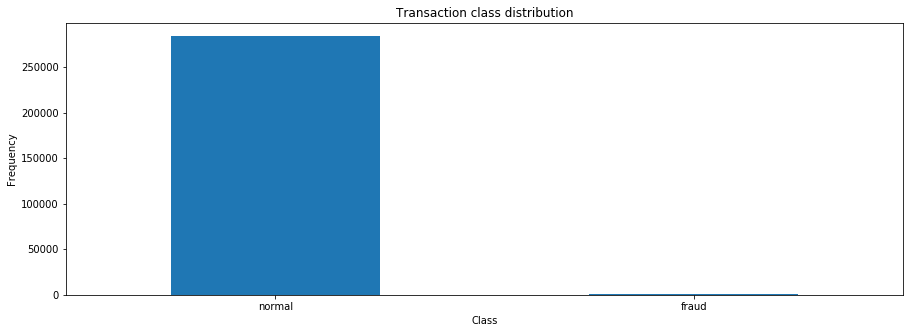

In [10]:
# Transaction class against the Frequency
labels = ['normal','fraud']
plt.figure(figsize=(15,5))
classes = pd.value_counts(creditData['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

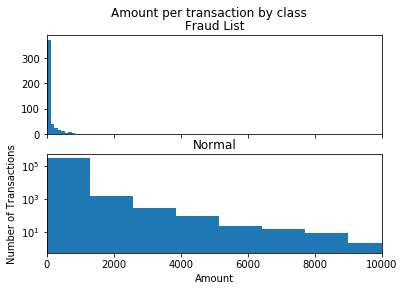

In [11]:
# Amount vs Class
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
ax1.hist(fraud.Amount, bins = 20)
ax1.set_title('Fraud List')
ax2.hist(normal.Amount, bins = 20)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show()

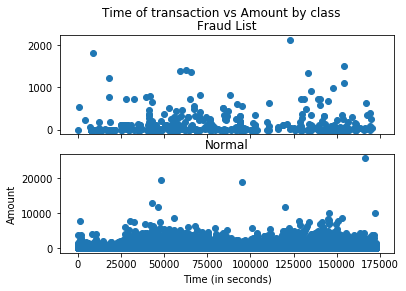

In [12]:
# Time vs Amount
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud List')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

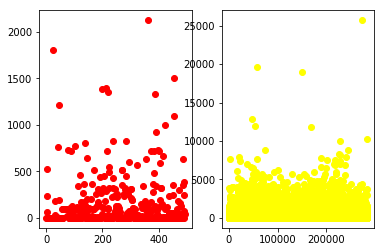

In [13]:
#plotting the dataset considering the class
color = {1:'red', 0:'yellow'}
fraudlist = creditData[creditData.Class == 1]
normal = creditData[creditData.Class == 0]
fig,axes = plt.subplots(1,2)
axes[0].scatter(list(range(1,fraudlist.shape[0] + 1)), fraudlist.Amount,color='red')
axes[1].scatter(list(range(1, normal.shape[0] + 1)), normal.Amount,color='yellow')
plt.show()

Preparing Data

The Time variable is not giving an impact on the model prediction. We can drop the unwanted variables.


In [14]:
features = creditData_h2o.drop(['Time'], axis=1)

Split the data frame as training set and testing set keeping 80% for the training set and rest to the testing set.

In [15]:
train, test = features.split_frame([0.8])
print(train.shape)
print(test.shape)

(227835, 30)
(56972, 30)


For the model training, we only send non-fraud transactions. So that the model will learn the pattern of normal transactions.

In [16]:
# converting to pandas dataframe
train_df = train.as_data_frame()
test_df = test.as_data_frame()

train_df = train_df[train_df['Class'] == 0]

# drop the Class variable
train_df = train_df.drop(['Class'], axis=1)

Y_test_df = test_df['Class'] # true labels of the testing set
test_df = test_df.drop(['Class'], axis=1)

print(train_df.shape)

(227428, 29)


Model Building


In [17]:
train_h2o = h2o.H2OFrame(train_df) # converting to h2o frame
test_h2o = h2o.H2OFrame(test_df)
x = train_h2o.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


When building the model, 4 fully connected hidden layers were chosen with, [14,7,7,14] number of nodes for each layer. First two for the encoder and last two for the decoder.

In [18]:
anomaly_model = H2ODeepLearningEstimator(activation = "Tanh",
                                         hidden = [14,7,7,14],
                                         epochs = 100,
                                         standardize = True,
                                         stopping_metric = 'MSE', 
                                         loss = 'automatic',
                                         train_samples_per_iteration = 128,
                                         shuffle_training_data = True,     
                                         autoencoder = True,
                                         l1 = 3e-4)
anomaly_model.train(x=x, training_frame = train_h2o)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Model Evaluation

Variable Importance : In H2O there is a special way of analyzing which variables are giving higher impact on the model.

In [19]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,V13,1.000000,1.000000,0.176804
1,V24,0.972803,0.972803,0.171995
2,V18,0.971105,0.971105,0.171695
3,V26,0.920512,0.920512,0.162750
4,V11,0.900905,0.900905,0.159283
5,V19,0.061154,0.061154,0.010812
6,Amount,0.053729,0.053729,0.009499
7,V28,0.048757,0.048757,0.008620
8,V20,0.047114,0.047114,0.008330
9,V21,0.043386,0.043386,0.007671


Visualization

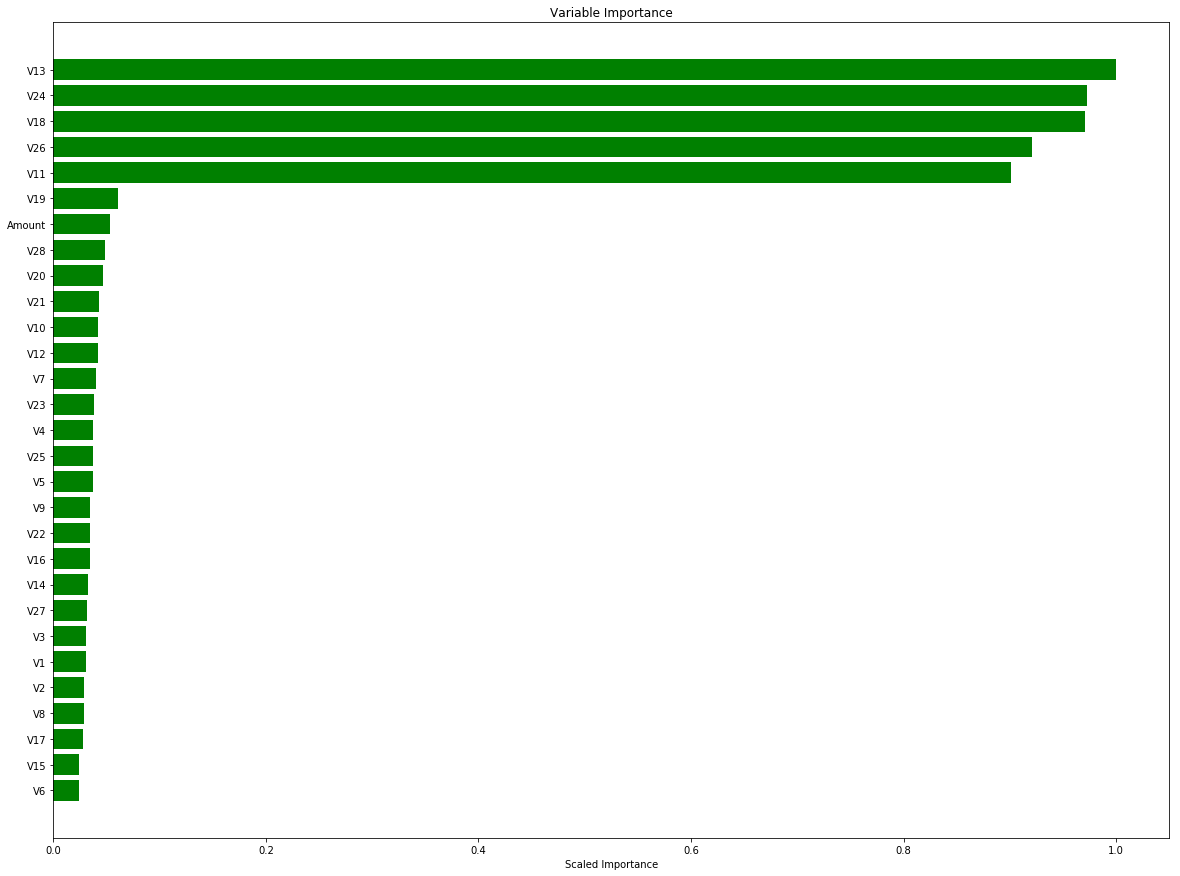

In [20]:
# plotting the variable importance
rcParams['figure.figsize'] = 20, 15

#plt.rcdefaults()
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

Text(0.5, 0, 'epoch')

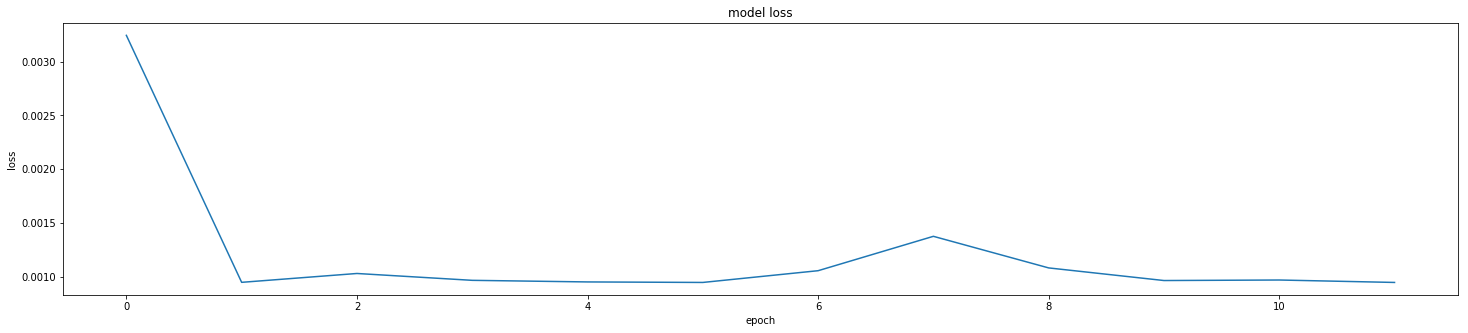

In [21]:
# plotting the loss
scoring_history = anomaly_model.score_history()
rcParams['figure.figsize'] = 25, 5
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

The Autoencoder will learn to identify the pattern of the input data. If an anomalous test point does not match the learned pattern, the autoencoder will likely have a high error rate in reconstructing this data, indicating anomalous data

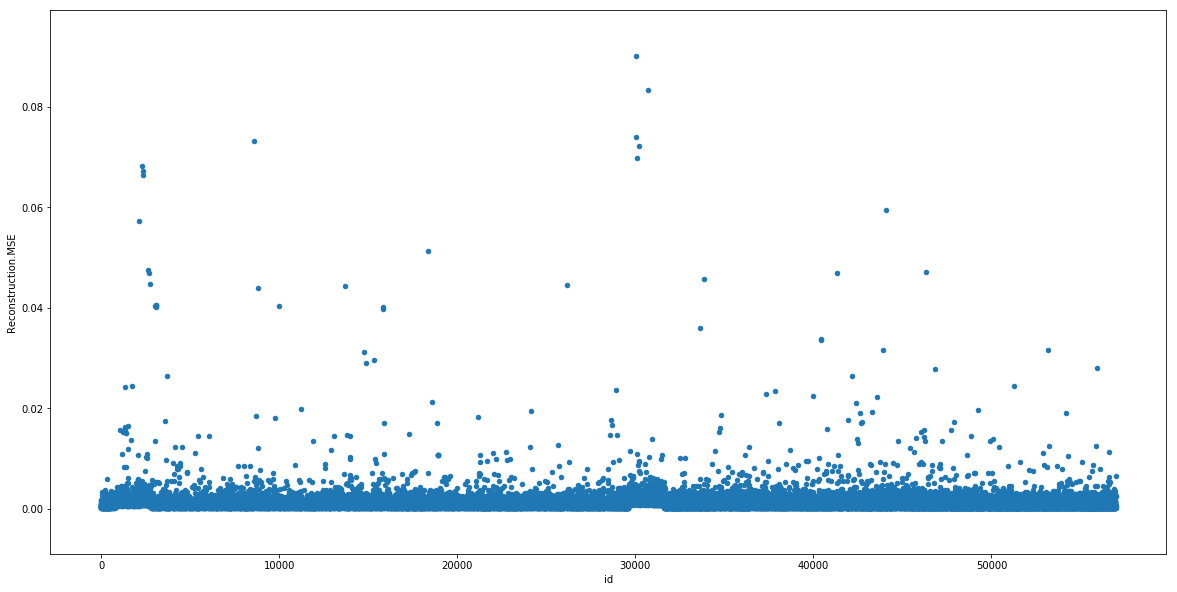

In [22]:
# anomaly is a H2O function which calculates the error for the dataset
test_rec_error = anomaly_model.anomaly(test_h2o) 

# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()

# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index

rcParams['figure.figsize'] = 20,10

test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [23]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.describe()

deeplearning prediction progress: |███████████████████████████████████████| 100%


,reconstruction_error,true_class
count,56972.000000,56972.000000
mean,0.000978,0.001492
std,0.001665,0.038597
min,0.000069,0.000000
25%,0.000423,0.000000
50%,0.000674,0.000000
75%,0.001144,0.000000
max,0.090197,1.000000


Reconstruction error for the normal transactions in the testing dataset


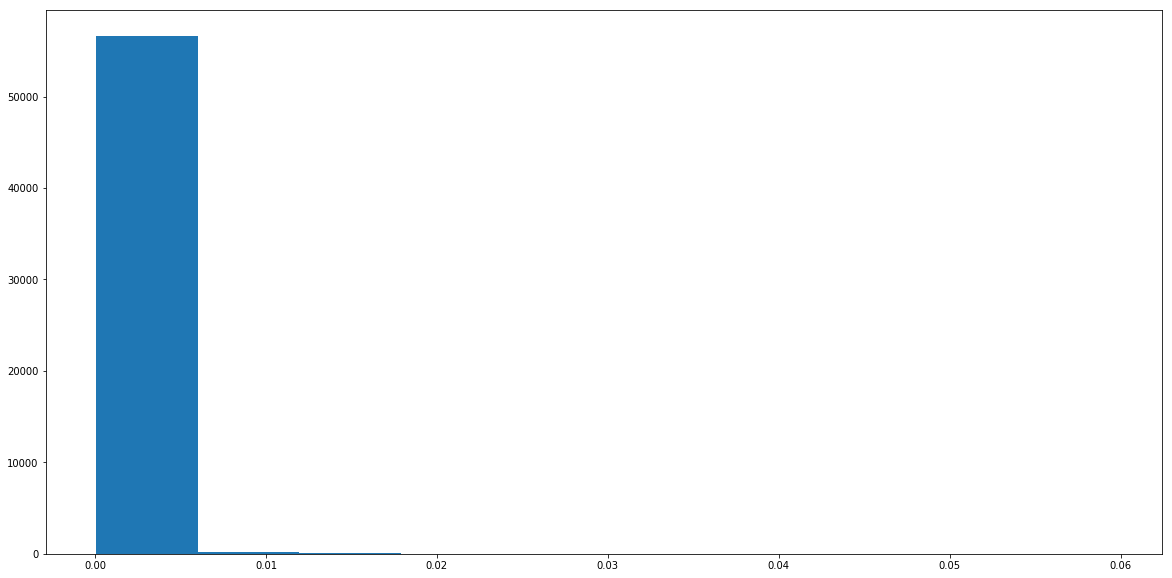

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 25, 5
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

Reconstruction error for the fraud transactions in the testing dataset


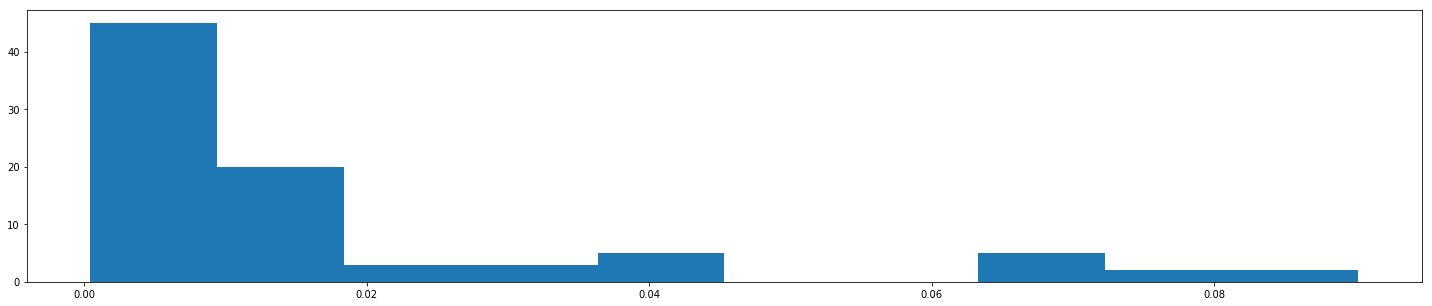

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 25, 5
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

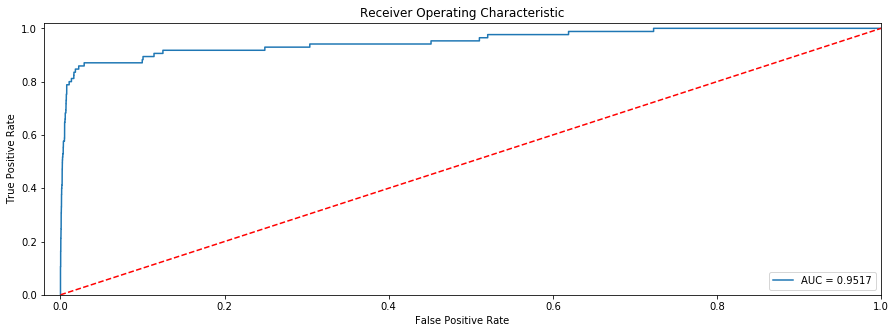

In [26]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Accuracy 

In [27]:
print('Accuracy is %0.3f' % (roc_auc*100))

Accuracy is 95.166


Precision & Recall
Since the data is highly imbalanced, it cannot be measured only by using accuracy.

Precision: Measuring the relevancy of obtained results.
[ True positives / (True positives + False positives)]

Recall: Measuring how many relevant results are returned.
[ True positives / (True positives + False negatives)]


True Positives — Number of actual frauds predicted as frauds
False Positives — Number of non-frauds predicted as frauds
False Negatives — Number of frauds predicted as non-frauds.

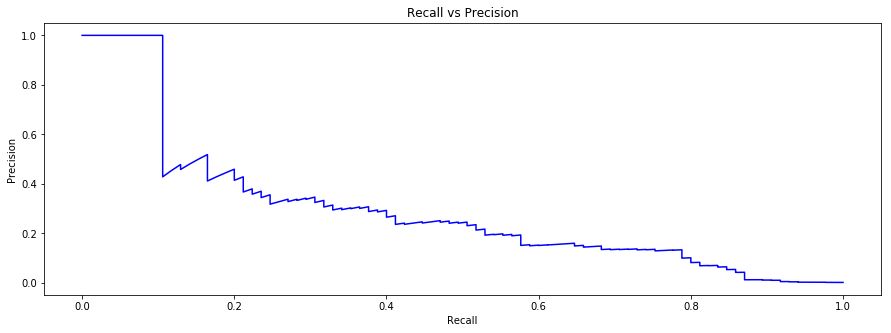

In [28]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

plt.figure(figsize=(15,5))
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We need to find a better threshold that can separate the anomalies from normal. This can be done by calculating the intersection of the Precision/Recall vs Threshold graph.

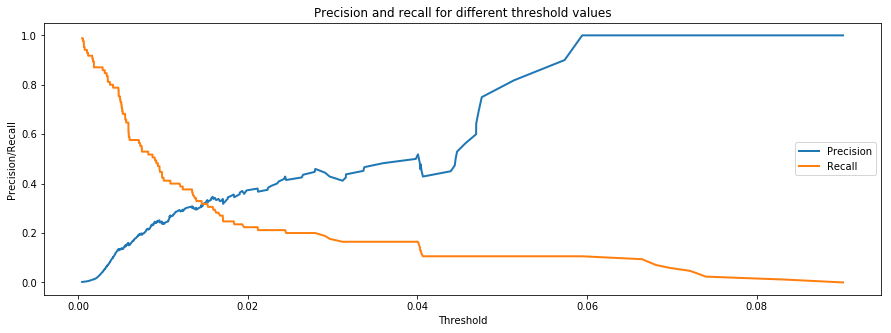

In [29]:
plt.figure(figsize=(15,5))
plt.plot(th, precision[1:], label="Precision",linewidth=2)
plt.plot(th, recall[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

<Figure size 720x360 with 0 Axes>

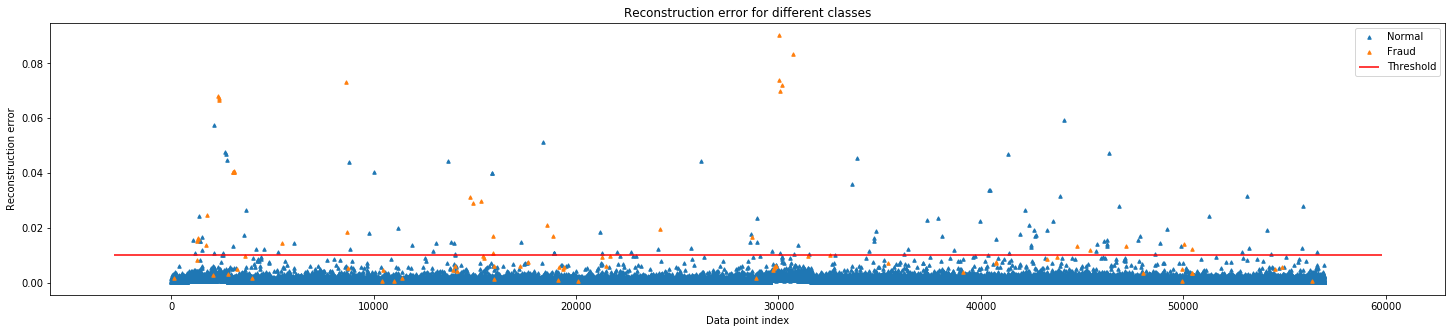

In [48]:
# plot the testing set with the threshold
threshold = 0.01
plt.figure(figsize=(10,5))
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

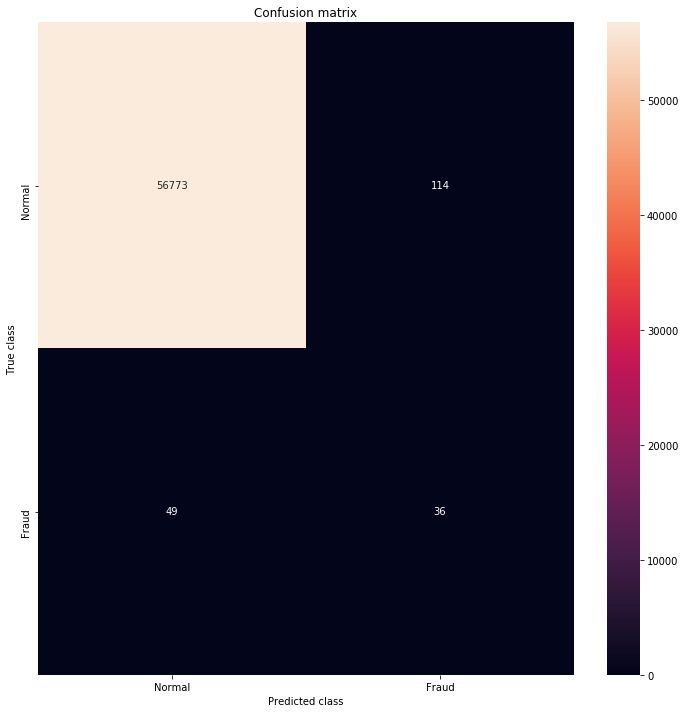

In [49]:

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [50]:
csr = classification_report(error_df.true_class, y_pred)
print(csr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56887
           1       0.24      0.42      0.31        85

    accuracy                           1.00     56972
   macro avg       0.62      0.71      0.65     56972
weighted avg       1.00      1.00      1.00     56972

